# Imports

In [1]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt
from batch.label_transforms.ahmet_refine_label_boundary import P_refine_label_boundary
from batch.data_transforms.ahmet_db_with_limits import db_with_limits, xr_db_with_limits
import seaborn as sns
from imblearn.under_sampling import NearMiss

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = 'C:/users/apa055/Desktop/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y
survey = readers[0]

# Selecting Data Portion

C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


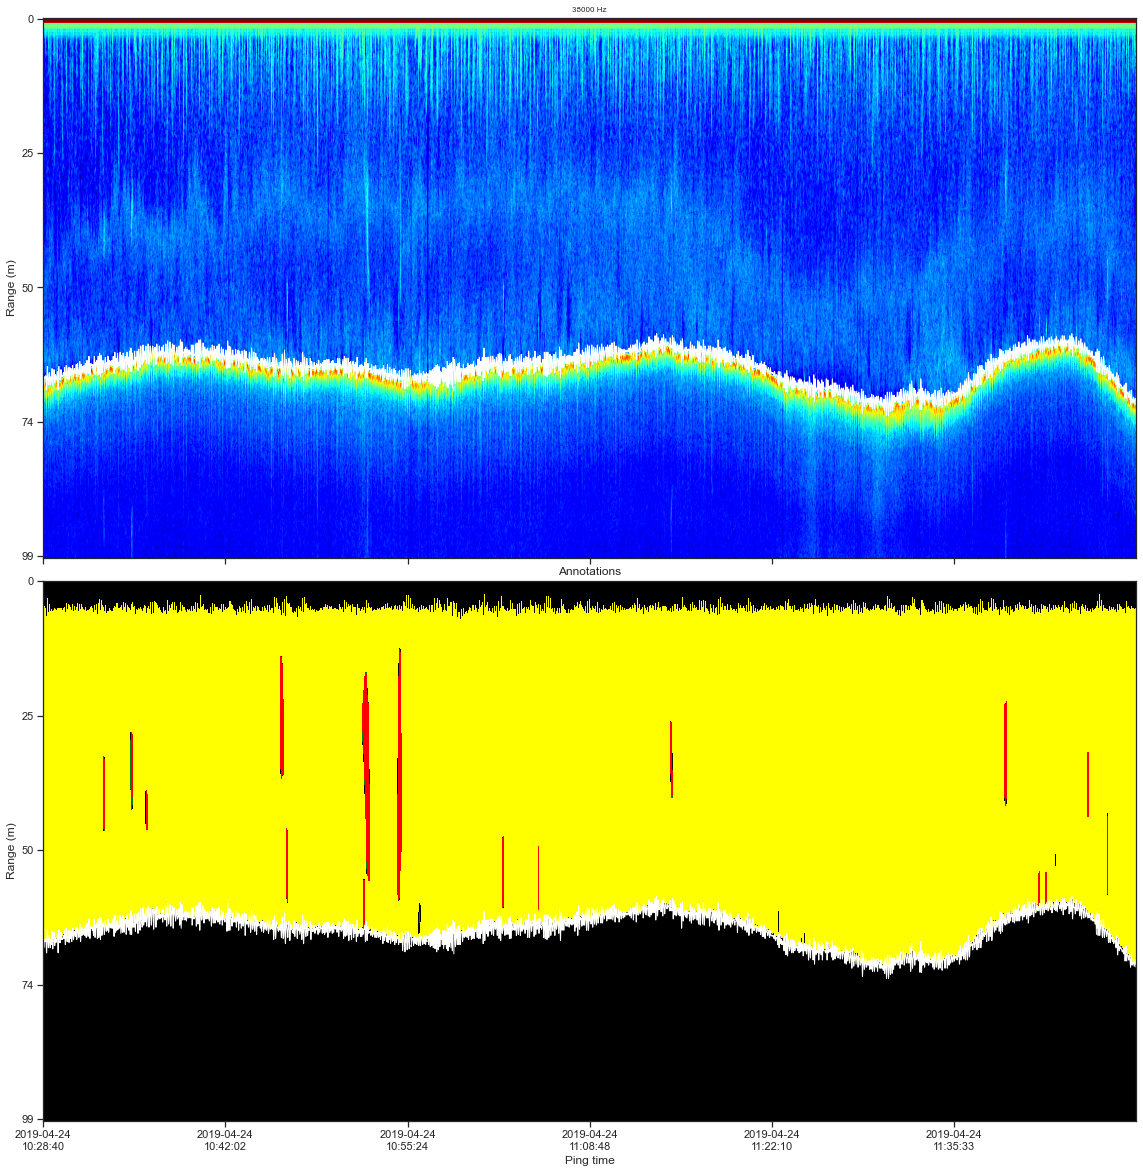

In [141]:
idx_ping = 55000 #46776
n_pings = 6000 #2000
idx_range = 0
n_range = 700

# selected echogram: ping_time = (46776:47276), range = (0:500) (500*500 = 250000 pixels * 4 frequency + 1 depth channel)

survey.visualize(ping_idx=idx_ping, n_pings=n_pings, range_idx=idx_range,
                 n_range=n_range, draw_seabed=True, show_labels=True, frequencies=[38000])

# Creating Data and Labels Arrays

In [142]:
# to get data slice
org_sv = survey.get_data_slice(idx_ping=idx_ping, n_pings=n_pings, idx_range=idx_range, n_range=n_range,
                                   return_numpy=False, frequencies=[18000, 38000, 120000, 200000])
data_Sv = xr_db_with_limits(org_sv)

# to get label slice
y_label = survey.get_label_slice(idx_ping=idx_ping, n_pings=n_pings, idx_range=idx_range, n_range=n_range,
                                 return_numpy=True)
# Update -1 Class
y_label[y_label==-1] = 0

# Annotation Modification
collection = P_refine_label_boundary(ignore_zero_inside_bbox=False, threshold_val=[1e-07, 1e-04],
                                       frequencies=[18, 38, 120, 200])(
    data=org_sv.values, labels=y_label,echogram=org_sv.values)

# Defining Sv data for 4 frequency channels and modified labels as numpy arrays
Sv_data, mod_labels = db_with_limits(collection[0]), collection[1]

C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


# Summary of the Labels

In [143]:
np.unique(mod_labels, return_counts=True)

(array([   0.,    1.,   27., 6009.], dtype=float32),
 array([4191180,     529,    8252,      39], dtype=int64))

# Creating Pandas Dataframe Containing Sv Data, Depth and Labels

In [144]:
# Creating flattened Numpy Array with frequency and depth
data_list = [Sv_data[i].flatten() for i in range(4)]
input_data_flat = np.asarray(data_list).T

# Converting into Pandas Dataframe
pd_all = pd.DataFrame(input_data_flat, columns=('18_Sv', '38_Sv', '120_Sv', '200_Sv'))
pd_all['label'] = mod_labels.flatten()
# Change labels column to 'object' datatype
pd_all.label = pd_all.label.astype('object')

# Visualization of each input pair

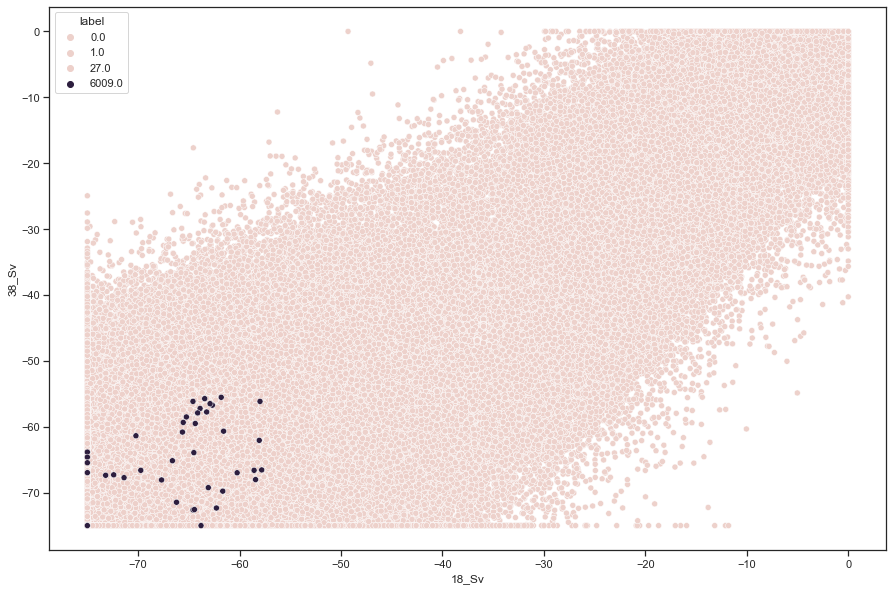

In [145]:
# Sandeel on top of Background
plt.figure(figsize=(15,10))
hue_order = ["27.0", "1.0", "0.0"]
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv", hue='label', hue_order=hue_order)
plt.show()

# Near Miss Algorithm

In [147]:
%%time
# 2000/0.025= 80000 samples of pixels, SD + Bg
nr = NearMiss(version=2, sampling_strategy={'0.0':len(mod_labels[mod_labels==27])})
#!!!! Nan Values should be filled if there is Nan
#pd_all.fillna(0, inplace=True)


X_train, y_train = pd_all.iloc[:,0:4], pd_all.iloc[:,4]
X_near, Y_near= nr.fit_resample(X_train, y_train.ravel().astype('str'))

Wall time: 25.7 s


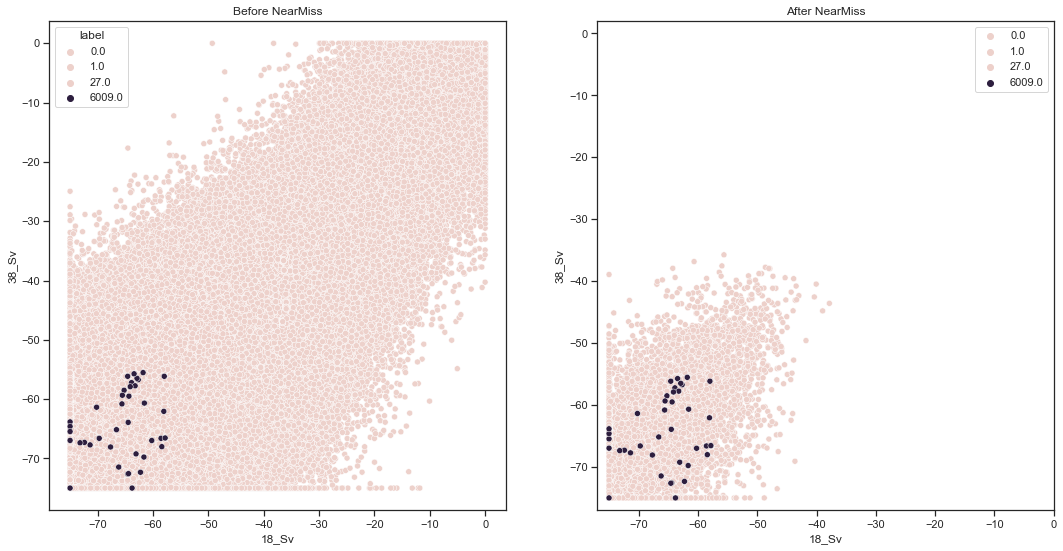

In [148]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(18,9))
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv",
                hue='label', ax=axes[0]).set(title='Before NearMiss')
sns.scatterplot(data=X_near, x="18_Sv", y="38_Sv", hue=Y_near.astype('float'),
                ax=axes[1]).set(title='After NearMiss')
plt.xlim(left=-77, right=0)
plt.ylim(-77, 2)
plt.show()

# Total samples by NearMiss Algorithm

In [149]:
np.unique(Y_near, return_counts=True)

(array(['0.0', '1.0', '27.0', '6009.0'], dtype='<U32'),
 array([8252,  529, 8252,   39], dtype=int64))

# Final Data

In [150]:
resulting_data = pd.DataFrame.copy(pd_all)
resulting_data['sampled'] = 0
# Assigning 1 for sampled pixels
for _, i in tqdm(enumerate(nr.sample_indices_), total=len(nr.sample_indices_)):
    resulting_data.iloc[i,5] = 2

100%|██████████| 17072/17072 [09:27<00:00, 30.08it/s]


In [151]:
resulting_data.label.value_counts()

0.0       4191180
27.0         8252
1.0           529
6009.0         39
Name: label, dtype: int64

In [152]:
# Creating Final Array

# Resizing sampled column
output = resulting_data['sampled'].values.reshape(n_pings, n_range).astype('float')
final_out=(output+resulting_data['label'].values.reshape(n_pings, n_range).astype('float'))

#Updating the annotation numbers
final_out[final_out==2], final_out[final_out==3], final_out[final_out==29]  = 0.5, 1, 27

# Plot Data Summary (Excluding Bg(0), Selected Bg, Other, Sandeel)

In [153]:
# Proportion of Disabled Bg, Selected Bg, Other, Sandeel, respectively
np.set_printoptions(suppress=True)
aa = np.round_(100*np.unique(final_out, return_counts=True)[1]/(final_out.shape[0]*final_out.shape[1]),2)
print(f'% {aa}')

% [99.59  0.2   0.01  0.2   0.  ]


In [154]:
np.unique(final_out, return_counts=True)

(array([   0. ,    0.5,    1. ,   27. , 6011. ]),
 array([4182928,    8252,     529,    8252,      39], dtype=int64))

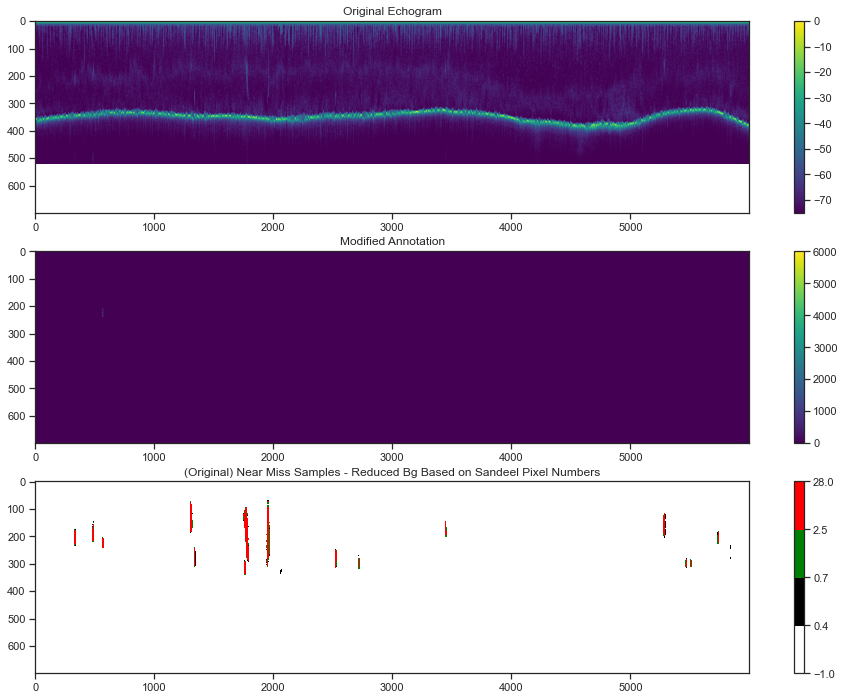

In [155]:
# Visualization of Near Miss Results
import matplotlib.colors as mcolors

cmap_labels = mcolors.ListedColormap(['white', 'black', 'green', 'red']) # green = other, red = sandeel
boundaries_labels = [-1, 0.4, 0.7, 2.5, 28]
norm_labels = mcolors.BoundaryNorm(boundaries_labels, cmap_labels.N, clip=True)

plt.figure(figsize=(16,12))
plt.subplot(3,1,3)
plt.title('(Original) Near Miss Samples - Reduced Bg Based on Sandeel Pixel Numbers')
plt.imshow(final_out.T,
           cmap=cmap_labels, norm=norm_labels, aspect='auto')
plt.colorbar()
plt.subplot(3,1,1)
plt.title('Original Echogram')
plt.imshow(data_Sv.sel(frequency=38000).values.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplot(3,1,2)
plt.title('Modified Annotation')
plt.imshow(mod_labels.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplots_adjust(wspace=0)
plt.autoscale(True)
plt.show()

# Taking Random 500 Samples from Sandeel, Selected Background, and Other

In [156]:
n = 200 # number of pixel coordinates for each class: Sandeel, Other, Selected Background
near_coordinates = np.zeros(shape=(n*3, 3)) # multiplication by 3 is for the total number of classes here
for i, cls in enumerate([0.5, 1, 27]):
    for j in range(n):
        cond = np.argwhere(final_out==cls)
        near_coordinates[(n*i)+j,:2] = cond[np.random.randint(len(cond))]
        near_coordinates[(n*i)+j,2] = cls


# Calculating Statistics for the Corresponding Coordinates

In [169]:
# Filtering exceeding patches
deneme_coord = near_coordinates[(near_coordinates[:,0]>=patch_size[0]//2) &
                                (near_coordinates[:,0]<=org_sv.shape[1]-patch_size[0]//2) &
                                (near_coordinates[:,1]>=patch_size[0]//2) &
                                (near_coordinates[:,1]<=org_sv.shape[2]-patch_size[0]//2)]
deneme_coord[:,0] = deneme_coord[:,0] + idx_ping
deneme_coord.shape

(502, 3)

In [ ]:
from utils.ahmet_patch_statistics_extract import GeneratePatchStat
deneme = GeneratePatchStat(readers[0], deneme_coord[:,:2].astype('int'), patch_size=(256,256))
deneme.calculate_stats(only_pixel_counts=False)

  0%|          | 0/502 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  0%|          | 1/502 [00:01<09:38,  1.15s/it]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  0%|          | 2/502 [00:02<08:47,  1.05s/it]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  1%|          | 3/502 [00:03<08:10,  1.02it/s]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
  1%|          | 4/502 [00:04<08:08,  1.02it/s]C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in lon

# Summary Information of the Extracted Patches Using Near Miss

In [160]:
# Patch Class Summaries
print(deneme.stats['class'].value_counts())
print(deneme.stats['class'].value_counts(normalize=True))

sandeel           56
seabed_sandeel    55
seabed             8
Name: class, dtype: int64
sandeel           0.470588
seabed_sandeel    0.462185
seabed            0.067227
Name: class, dtype: float64


In [168]:
# Pixelwise Percentages
ot, sd, bg, sm = deneme.stats.nop_other.sum(), deneme.stats.nop_sandeel.sum(), deneme.stats.nop_background.sum(), (deneme.stats.nop_other.sum()+deneme.stats.nop_sandeel.sum()+deneme.stats.nop_background.sum())
print(f'Other = % {(100*ot/sm):.2f}, Sandeel = % {100*sd/sm:.2f}, Background = % {100*bg/sm:.2f}')

Other = % 0.00, Sandeel = % 3.17, Background = % 96.83


# Example Visualizations

In [97]:
deneme.stats.sort_values('nop_sandeel', ascending=False).head(20)

,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,...,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,class
281,47010.0,189.0,-72.030899,-75.0,4.790866,-75.0,-75.0,-75.000000,-70.070023,-63.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sandeel
272,47009.0,202.0,-71.875397,-75.0,4.890502,-75.0,-75.0,-75.000000,-69.751226,-62.848779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
388,47008.0,182.0,-72.024437,-75.0,4.831581,-75.0,-75.0,-75.000000,-70.082863,-62.962158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sandeel
385,46936.0,194.0,-71.527031,-75.0,5.427925,-75.0,-75.0,-74.703018,-69.149811,-62.187853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
274,47010.0,211.0,-71.515785,-75.0,6.057146,-75.0,-75.0,-74.848522,-69.374458,-62.236895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
378,47005.0,184.0,-72.016350,-75.0,4.824190,-75.0,-75.0,-75.000000,-70.052254,-62.993603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sandeel
393,46934.0,197.0,-71.403275,-75.0,5.857561,-75.0,-75.0,-74.576351,-69.044004,-62.031685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
330,47005.0,200.0,-71.901161,-75.0,4.898637,-75.0,-75.0,-75.000000,-69.807640,-62.927273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
332,46936.0,206.0,-70.902084,-75.0,7.403933,-75.0,-75.0,-74.242821,-68.644192,-61.133162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel
361,46936.0,197.0,-71.414169,-75.0,5.854379,-75.0,-75.0,-74.608612,-69.065815,-62.047595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabed_sandeel


In [98]:
deneme_coord

array([[4.7289e+04, 3.9100e+02, 5.0000e-01],
       [4.8233e+04, 3.4800e+02, 5.0000e-01],
       [4.8401e+04, 3.4100e+02, 5.0000e-01],
       ...,
       [4.8100e+04, 2.0000e+02, 2.7000e+01],
       [4.8625e+04, 2.5400e+02, 2.7000e+01],
       [4.8095e+04, 1.9500e+02, 2.7000e+01]])

1.0


C:\Anaconda3\lib\site-packages\dask\array\slicing.py:637: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


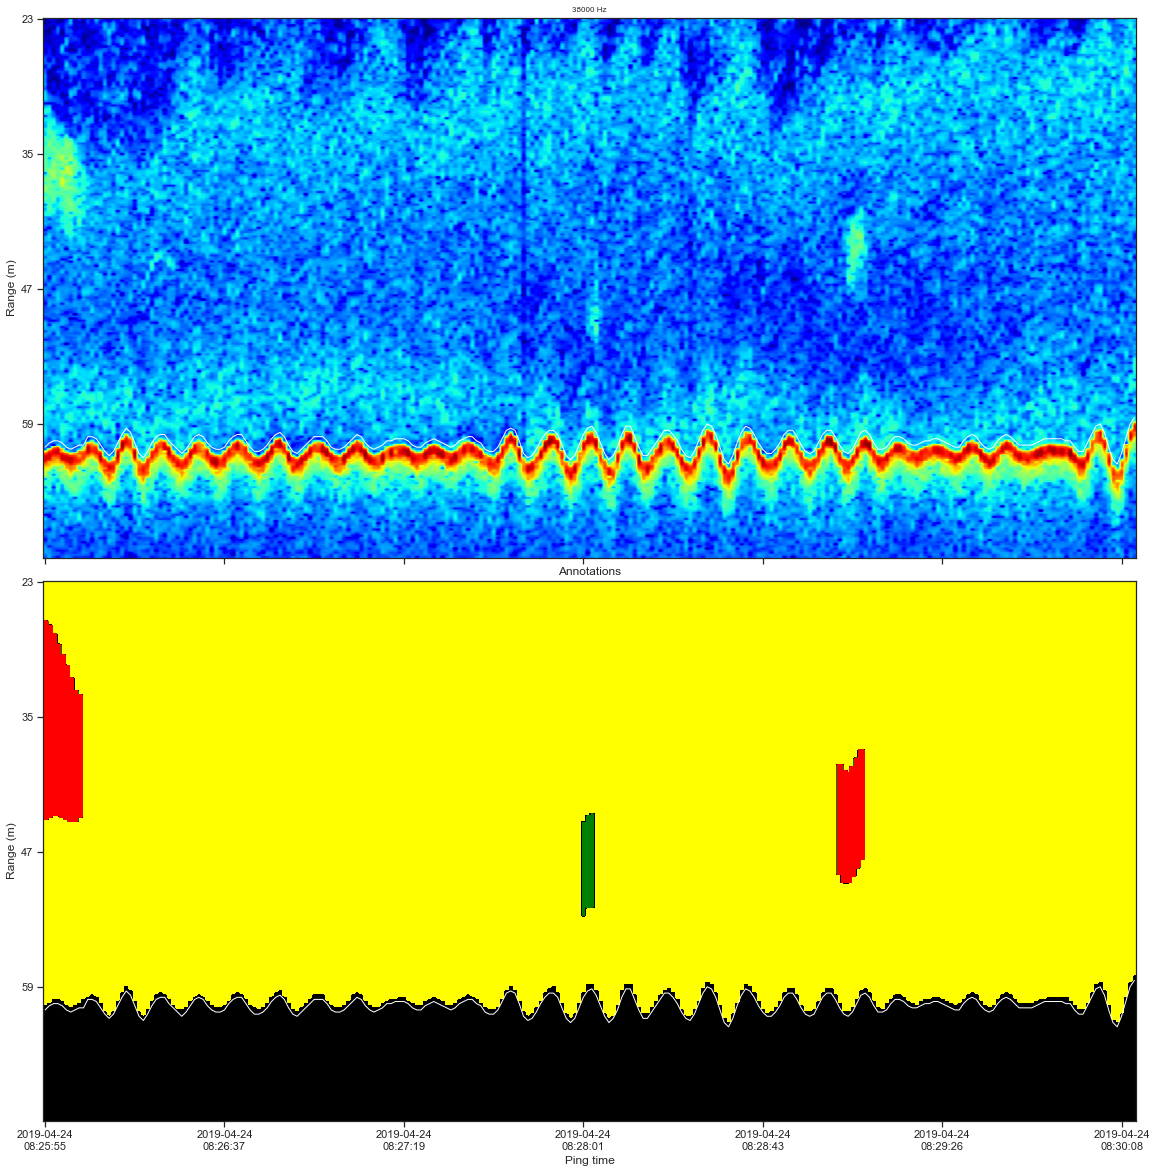

In [100]:
row = 200
ping_idx = int(deneme_coord[row, 0]) - 128
range_idx = int(deneme_coord[row, 1]) - 128
print(deneme_coord[row, 2])
survey.visualize(ping_idx, n_pings=256, range_idx=range_idx, n_range=256, frequencies=[38000])